<a href="https://colab.research.google.com/github/tteague19/xlab-security-course/blob/main/notebooks/06-robust_bench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RobustBench and AutoAttack

In [7]:
!pip install xlab-security robustbench git+https://github.com/fra31/auto-attack

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-6tlkycav
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-6tlkycav
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done
  Using cached robustbench-1.1.1-py3-none-any.whl.metadata (90 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.7 MB/s eta 0:00:00
  Created wheel for autoattack: filename=autoattack-0.1-py3-none-any.whl size=36228 sha256=900e11ed06fb1f283513f16552525eabb14ef7d22fe5cc85a6887591e4d8b4c4
  Stored in directory: /tmp/pip-ephem-wheel-c

In [8]:
import xlab  # for testing your code

# get CIFAR10 helper functions
from xlab.utils import CIFAR10

itos, stoi = CIFAR10.itos, CIFAR10.stoi

from robustbench.utils import load_model
from robustbench.data import load_cifar10
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from autoattack import AutoAttack
import pickle
import numpy as np

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

We will begin by loading a pretrained model for classification on CIFAR using `robustbench`.

In [9]:
model = load_model(model_name="Standard", threat_model="Linf")
model = model.to(device)
_ = model.eval()

Downloading...
From (original): https://drive.google.com/uc?id=1t98aEuzeTL8P7Kpd5DIrCoCL21BNZUhC
From (redirected): https://drive.google.com/uc?id=1t98aEuzeTL8P7Kpd5DIrCoCL21BNZUhC&confirm=t&uuid=e1309927-88f6-48a4-a265-8b618faa2a1b
To: /content/models/cifar10/Linf/Standard.pt
100%|██████████| 292M/292M [00:03<00:00, 86.9MB/s]


First, let's take a look at what we have. We can see that there is about 36.5 million trainable parameters in the model. This is actually quite large! For reference, we will be looking at the smallest version of GPT-2 later in the course. That has 128 million parameters, meaning our classifier is about a third of the size of the smallest transformer-based language models.

In [10]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


Next, let's look at the architecture. We can see that this is the Wide ResNet we discussed earlier in this course. We encourage you to take a look at the model structure to see if you can infer what is going on.

In [11]:
model

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

## Task 1: Benchmark Wide ResNet on Clean Images

Now let's see how robust this base model is. First we will want to benchmark the accuracy of clean images. For computational efficiency, we will only load 100 images from [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). If you would like to load more, and your computer can handle it, we encourage you to do so!

In [12]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

100%|██████████| 170M/170M [00:02<00:00, 79.8MB/s]


x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


<details>
<summary>💡 <b>Hint for Task #1</b></summary>

In our solution we use `logits = model(imgs)` to get logits for every image passed into the function. You can do the same thing with a loop, but it is less efficient and there are more variables to keep track of, potentially leading to small bugs.

</details>



<details>
<summary>💡 <b>Hint for Task #1</b></summary>

In our solution we use `torch.sum(pred_labels == labels)` to efficiently calculate how many predicted labels match the true values.

</details>

<details>
<summary>🔐 <b>Solution for Task #1</b></summary>

```python
def benchmark_wideresnet(model, imgs, labels):
    '''return the accuracy of the model as a floating point number between 0.0 and 1.0'''
    acc = 0

    logits = model(imgs)
    pred_labels = torch.argmax(logits, dim=1)
    num_correct = torch.sum(pred_labels == labels)
    total_imgs = len(labels)
    acc = num_correct/total_imgs
    
    return acc.item()
```

</details>

In [13]:
def benchmark_wideresnet(model, imgs, labels):
    """Calculates model accuracy on given images and labels.

    Args:
        model: Trained neural network model with forward pass.
        imgs: Input images tensor [batch, 3, 32, 32].
        labels: True class labels tensor [batch].

    Returns:
        Float accuracy between 0.0 and 1.0.
    """
    acc = 0

    ########### YOUR CODE HERE ###########
    logits = model(imgs)
    pred_labels = torch.argmax(logits, dim=1)
    num_correct = torch.sum(pred_labels == labels)
    total_imgs = len(labels)
    acc = num_correct / total_imgs

    return acc


acc = benchmark_wideresnet(model, x_test, y_test)
print(f"Model accuracy is {acc * 100:.2f}% for clean images")

Model accuracy is 94.00% for clean images


In [14]:
# This test will make sure you have reasonable accuracy for the first 100 testing images.
# Do NOT change the function below: you do not need to pass in any images or labels.
_ = xlab.tests.robustbench.task1(benchmark_wideresnet, model)


Running tests for Section 2.4.2, Task 1...
🎉 All tests passed! (2/2)

Detailed output:
============================= test session starts ==============================
collecting ... collected 25 items / 23 deselected / 2 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_model_accuracy_above_80_percent PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_student_function_accuracy_matches_model PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
============ 2 passed, 23 deselected, 1 warning in 69.39s (0:01:09) ======

## Targeted Attack on Model

To show how vulnerable this pretrained model is to adversarial attacks, we will benchmark it on a CW attack with only 100 total iterations.

As a refresher, the code below shows how to run a targeted CW attack. In this example, we take an image of a horse and generate an example that the model classifies as a frog.

In [15]:
img_idx = 13  # this is an image of a horse
true_class_idx = y_test[img_idx].item()
target_class = "bird"

print(f"Running CW to misclasify {itos[true_class_idx]} as {target_class}...")

adv_image = xlab.utils.CW_targeted_l2(
    x_test[img_idx : img_idx + 1],
    model,
    c=0.015,
    target=stoi[target_class],
    num_iters=100,
    l2_limit=0.75,
)

model_adv_pred = torch.argmax(model(adv_image)).item()
model_clean_pred = torch.argmax(model(x_test[img_idx : img_idx + 1].to(device))).item()

print(
    f"Clean Predicted Label = '{itos[model_clean_pred]}', Adversarial Predicted Label = '{itos[model_adv_pred]}'"
)

Running CW to misclasify horse as bird...
Using device: cpu for testing...
Clean Predicted Label = 'horse', Adversarial Predicted Label = 'bird'


## Task #2: Benchmark on CW Attacks

<details>
<summary>💡 <b>Hint for Task #2</b></summary>

For `xlab.utils.CW_targeted_l2`, you should be
1. passing a python integer to target: e.g., ` target=int(targets[i].item())`.
2. passing an image with a batch dimension of 1 (i.e., the tensor will be [1,3,32,32]).

</details>




<details>
<summary>🔐 <b>Solution for Task #2</b></summary>

```python
# you are free to change the function header, but this is the one the solution will have
def get_targeted_cw_imgs(model, imgs, targets, steps=30, c=0.02, l2_limit=0.75):
    """Generates adversarial examples using targeted Carlini-Wagner attack.
    
    Args:
        model: Target neural network model.
        imgs: Input images tensor [batch, 3, 32, 32].
        targets: Target class indices tensor [batch].
        steps: Number of optimization iterations.
        c: Attack strength parameter.
        l2_limit: Maximum L2 perturbation allowed.
    
    Returns:
    """
    adv_imgs = []

    for i in range(imgs.shape[0]):
        print(f"running CW on image {i + 1} of {imgs.shape[0]}...")
        adv_img = xlab.utils.CW_targeted_l2(imgs[i:i+1], model, c=c, target=int(targets[i].item()), num_iters=steps, l2_limit=l2_limit)
        adv_imgs.append(adv_img)
    
    return adv_imgs
```

</details>

In [20]:
# you are free to change the function header, but this is the one the solution will have
def get_targeted_cw_imgs(model, imgs, targets, steps=30, c=0.02, l2_limit=0.75):
    """Generates adversarial examples using targeted Carlini-Wagner attack.

    Args:
        model: Target neural network model.
        imgs: Input images tensor [batch, 3, 32, 32].
        targets: Target class indices tensor [batch].
        steps: Number of optimization iterations.
        c: Attack strength parameter.
        l2_limit: Maximum L2 perturbation allowed.

    Returns:
        Python ist of adversarial image tensors (each element is a [1, 3, 32, 32] tensor).
    """
    adv_imgs = []

    ########### YOUR CODE HERE ###########
    for img_idx in range(imgs.shape[0]):
      adv_img = xlab.utils.CW_targeted_l2(
        imgs[img_idx].unsqueeze(0),
        model,
        c=c,
        target=torch.tensor(targets[img_idx], dtype=torch.long),
        num_iters=steps,
        l2_limit=l2_limit,
      )
      adv_imgs.append(adv_img)

    return adv_imgs

In [21]:
target_classes = (torch.ones((5,)) * stoi["frog"]).to(device)

# we use quite a large L_2 limit for efficiency. you are free to try something more reasonable and increase the number of steps
task_2_imgs = get_targeted_cw_imgs(
    model, x_test[:5].to(device), target_classes, steps=50, c=0.03, l2_limit=2
)

/tmp/ipython-input-2606033296.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target=torch.tensor(targets[img_idx], dtype=torch.long),


Using device: cpu for testing...
Using device: cpu for testing...
Using device: cpu for testing...
Using device: cpu for testing...
Using device: cpu for testing...


In [22]:
# this test will confirm that each of the adversarial images are classified as "frog"
_ = xlab.tests.robustbench.task2(task_2_imgs, model)


Running tests for Section 2.4.2, Task 2...
🎉 All tests passed! (1/1)

Detailed output:
============================= test session starts ==============================
collecting ... collected 25 items / 24 deselected / 1 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_all_images_classify_as_frog PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
================= 1 passed, 24 deselected, 2 warnings in 1.22s =================



We encourage you to play around with the attack you have built to show how brittle a high accuracy classifier can be. Despite having near perfect performance on clean data, you will find that you will be able to fool the model into classifying images from any class to most of the other classes with a reasonable $L_2$ limit.

## Shattering Gradients: Demonstrating the Failures of Benchmarks

Now we will propose a defense and benchmark it on two variations of PGD which will give us a false sense of confidence in our defense. In other words, we will be doing what many researchers have been doing for years. As the AutoAttack paper states:

<blockquote>
    <i>Another cause of poor evaluations is the lack of diversity among the attacks used, as most papers rely solely
        on the results given by PGD or weaker versions of it like FGSM.
    </i>
</blockquote>
    
We will show how doing this can fail in the most extreme way by demonstrating a defense that works quite well against PGD but fails entirely on a black box attack. Admittedly, the defense that we cover is perhaps too silly for most researchers to take completely seriously, but we believe that by working through this example, you will develop good intuitions about how benchmarking attack success can be misleading.

To be very clear: <b>We do not present the below defense because it is good.</b> We present it because it will <i>appear</i> good
under a poorly designed evaluation. There is actually a famous paper which exposes these kinds of defenses titled [Obfuscated Gradients Give a False Sense of Security: Circumventing Defenses to Adversarial Examples](https://arxiv.org/pdf/1802.00420) which we will discuss more at the end of the notebook.

Time to dive into our "defense." If you print the model, you will see that the model is using a [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). ReLU non-linearities give very clean gradients:

$$
\frac{d}{dx}\text{ReLU}(x) = \frac{d}{dx}\max(0, x) = \begin{cases}
1 & \text{if } x > 0 \\
0 & \text{if } x < 0 \\
\text{undefined} & \text{if } x = 0
\end{cases}
$$

In PyTorch, when x=0, the gradient of x is 0 rather than being undefined. We can demonstrate the above equation with the code below.

In [23]:
x_1 = torch.tensor(0.0, requires_grad=True)
x_2 = torch.tensor(-1.0, requires_grad=True)
x_3 = torch.tensor(1.0, requires_grad=True)

for x in [x_1, x_2, x_3]:
    out = F.relu(x)
    out.backward()

print(x_1.grad, x_2.grad, x_3.grad)

tensor(0.) tensor(0.) tensor(1.)


We can calculate the gradient of the input to a ReLU tensor in the following manner:

In [24]:
def ReLU_grad(x):
    grad = torch.ones_like(x)
    grad[x <= 0] = 0
    return grad

We will now build out a defense where we manipulate the gradients of the ReLU activation function without doing much to affect the forward pass. Consider the following variation of ReLU which we will call WiggleReLU:

$$
\text{WiggleReLU}(x) = \text{ReLU}(x) + \alpha \sin(\omega x) = \max(0, x) + \alpha \sin(\omega x)
$$

This gives the following gradients:

$$
\frac{d}{dx}\text{WiggleReLU}(x) = \begin{cases}
1 + \alpha \omega \cos(\omega x) & \text{if } x > 0 \\
\alpha \omega \cos(\omega x) & \text{if } x \leq 0
\end{cases}
$$

Depending on the magnitude of the amplitude parameter ($\alpha$) and the frequency parameter ($\omega$), you will get increasing different gradients compared to the vanilla ReLU function. In task #3 and #4 you will implement WiggleReLU, and examine the gradients it produces. In task #5, you will show that by substituting all ReLUs with WiggleReLU in our original model, attacks like PGD, CW, or FGSM will no longer work.

## Task #3 WiggleReLU

<details>
<summary>🔐 <b>Solution for Task #3</b></summary>

```python
def wiggle_ReLU(x, amplitude=0.1, frequency=40):
    """Applies WiggleReLU activation: ReLU(x) + amplitude * sin(frequency * x).
    
    Args:
        x: Input tensor [*].
        amplitude: Sine wave amplitude parameter.
        frequency: Sine wave frequency parameter.
    
    Returns:
        Tensor [*] with WiggleReLU activation applied.
    """
    return F.relu(x) + amplitude * torch.sin(x * frequency)
```

</details>

In [25]:
def wiggle_ReLU(x, amplitude=0.1, frequency=40):
    """Applies WiggleReLU activation: ReLU(x) + amplitude * sin(frequency * x).

    Args:
        x: Input tensor [*].
        amplitude: Sine wave amplitude parameter.
        frequency: Sine wave frequency parameter.

    Returns:
        Tensor [*] with WiggleReLU activation applied.
    """
    return  F.relu(x) + amplitude * torch.sin(x * frequency)

In [26]:
_ = xlab.tests.robustbench.task3(wiggle_ReLU)


Running tests for Section 2.4.2, Task 3...
🎉 All tests passed! (10/10)

Detailed output:
============================= test session starts ==============================
collecting ... collected 25 items / 15 deselected / 10 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_implementation[input_tensor0-0.1-150-1D tensor, default params] PASSED [ 10%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_implementation[input_tensor1-0.1-150-2D tensor, default params] PASSED [ 20%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_implementation[input_tensor2-0.1-150-3D tensor, default params] PASSED [ 30%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_implementation[input_tensor3-0.05-150-1D tensor, amplitude=0.05] PASSED [ 40%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_implementation[input_

Let's take a look at what WiggleRELU looks like when we plot it:

In [27]:
amplitude = 0.1
frequency = 40
x_vals = torch.arange(-5, 5.01, 0.01)
y_vals = wiggle_ReLU(x_vals, amplitude=amplitude, frequency=frequency)

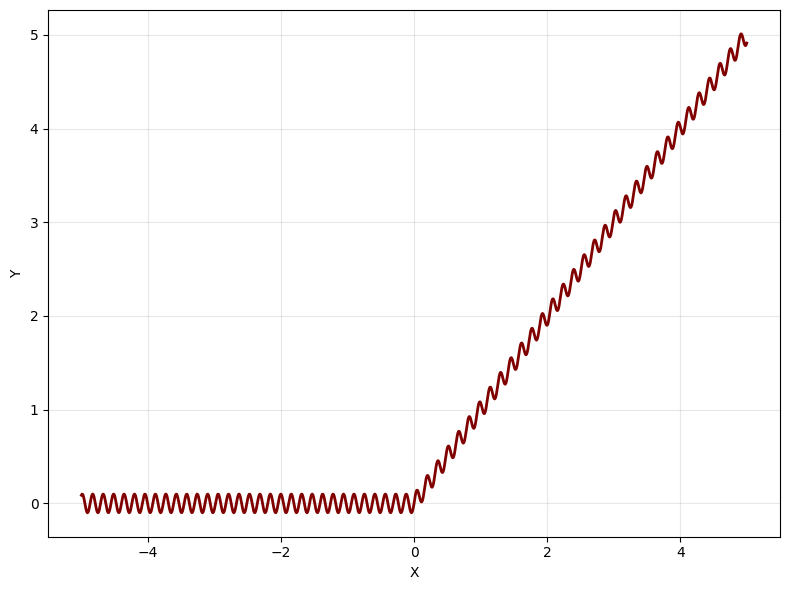

In [28]:
_ = xlab.utils.plot_2d(
    x_vals, y_vals, x_range=None, y_range=None, title=None, figsize=(8, 6)
)

## Task #4 WiggleReLU gradient

In our solution to task #4, we clone x and calculate the gradient using PyTorch's autograd. We also encourage you to try to implement the solution without autograd (to do this you would find the derivative of WiggleReLU by hand).

<details>
<summary>💡 <b>Hint for Task #4</b></summary>

If you are computing wiggle_Relu_grad, you cannot call out.backward() if out is a non-scalar tensor. You can do torch.sum(out).backward() to effectively call backward on each out the outputs. The reason this works is the partial derivative of each input to a sum function is always 1.

</details>

<details>
<summary>🔐 <b>Solution for Task #4</b></summary>

```python
def wiggle_ReLU_grad(x, amplitude=0.1, frequency=40):
    """Computes gradient of WiggleReLU function with respect to input.
    
    Args:
        x: Input tensor [*].
        amplitude: Sine wave amplitude parameter.
        frequency: Sine wave frequency parameter.
    
    Returns:
        Gradient tensor [*] same shape as input.
    """
    x_cloned = x.clone().requires_grad_(True)
    out = wiggle_ReLU(x_cloned, amplitude, frequency)
    torch.sum(out).backward()
    
    return x_cloned.grad
```

</details>

In [31]:
def wiggle_ReLU_grad(x, amplitude=0.1, frequency=40):
    """Computes gradient of WiggleReLU function with respect to input.

    Args:
        x: Input tensor [*].
        amplitude: Sine wave amplitude parameter.
        frequency: Sine wave frequency parameter.

    Returns:
        Gradient tensor [*] same shape as input.
    """
    grad = torch.zeros_like(x)  # you can overwrite this if you would like

    ########### YOUR CODE HERE ###########
    x_cloned = x.clone().requires_grad_(True)
    out = wiggle_ReLU(x_cloned, amplitude, frequency)
    torch.sum(out).backward()

    return x_cloned.grad

In [32]:
_ = xlab.tests.robustbench.task4(wiggle_ReLU_grad)


Running tests for Section 2.4.2, Task 4...
🎉 All tests passed! (12/12)

Detailed output:
============================= test session starts ==============================
collecting ... collected 25 items / 13 deselected / 12 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_grad_implementation[input_tensor0-0.1-150-1D tensor, default params] PASSED [  8%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_grad_implementation[input_tensor1-0.1-150-2D tensor, default params] PASSED [ 16%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_grad_implementation[input_tensor2-0.1-150-3D tensor, default params] PASSED [ 25%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_grad_implementation[input_tensor3-0.05-150-1D tensor, amplitude=0.05] PASSED [ 33%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/robustbench.py::test_wiggle_relu_g

Now let's take a look how wiggle_ReLU scrambles gradients. In the plot below you should observe two things:

1. That the `ReLU Clean Output` plot should display a similar pattern to the `WiggleReLU Output`
2. That the `ReLU Clean Grad` plot should display a <b><i>very different</i></b> pattern compared to the `WiggleReLU Grad`

In other words, the forward pass will look mostly the same with the WiggleReLU, but the backward pass should be mostly scrambled. This means that when we try to take a gradient using something like CW, we won't get a reliable signal.

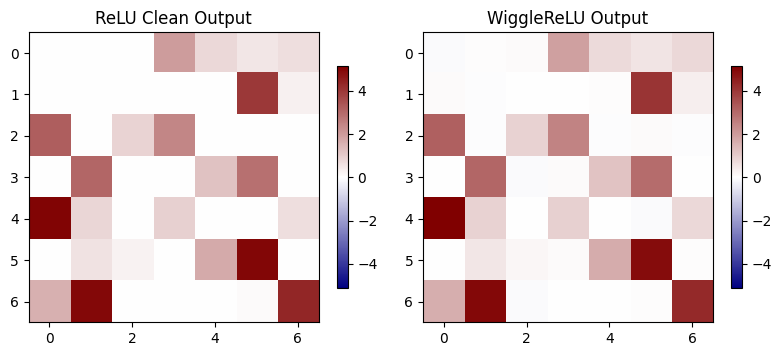

In [33]:
input_tensor = torch.randn((7, 7)) * 3

relu_out = F.relu(input_tensor)
relu_grad = ReLU_grad(input_tensor)

wiggle_relu_out = wiggle_ReLU(input_tensor)
wiggle_relu_grad = wiggle_ReLU_grad(input_tensor)

# this will display the differnce between the output of ReLU and WiggleReLU
# these tensors should look nearly identical
_ = xlab.utils.plot_tensors(
    [relu_out, wiggle_relu_out],
    log_scale=False,  # if you switch this to True, you will see that the tensors are in fact not identical
    titles=["ReLU Clean Output", "WiggleReLU Output"],
)

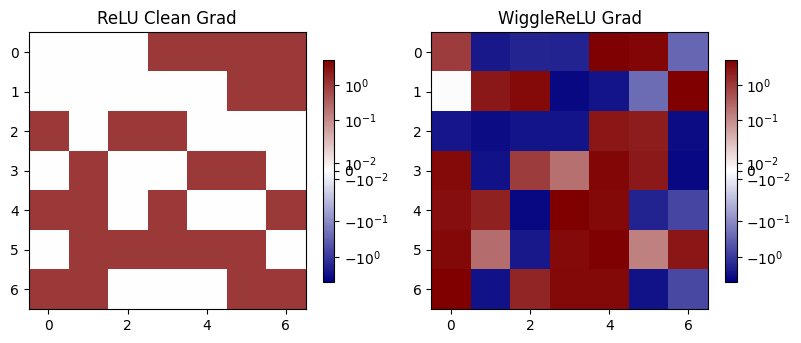

In [34]:
_ = xlab.utils.plot_tensors(
    [relu_grad, wiggle_relu_grad],
    log_scale=True,  # we switch this to true because some WiggleReLU gradients are quite large
    titles=["ReLU Clean Grad", "WiggleReLU Grad"],
)

## Task #5 Replacing ReLU with WiggleReLU

To replace the ReLU functions within the model, we need to make wiggle_ReLU a class that inherits the `nn.Module` class. We have taken care of creating this class for you below.

In [35]:
class WiggleReLU(nn.Module):
    def __init__(self, amplitude=0.1, frequency=40):
        super(WiggleReLU, self).__init__()
        self.frequency = frequency
        self.amplitude = amplitude

    def forward(self, x):
        return wiggle_ReLU(
            x, amplitude=self.amplitude, frequency=self.frequency
        )  # this is the function you implemented for task 3

Now you will replace all of the ReLU activations in our pretrained model with the WiggleReLU class.
Once you have modified your modified model, you will pass it to `xlab.tests.robustbench.task4` which will confirm that your implementation is correct.

<details>
<summary>💡 <b>Hint 1 for Task #5</b></summary>

You can extract a ReLU activation from the model using the following code:
`model.block1.layer[0].relu1`

</details>

<details>
<summary>💡 <b>Hint 2 for Task #5</b></summary>

You can replace a ReLU activation from the model using the following code:
`model.block1.layer[0].relu1 = WiggleReLU()`

</details>

<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
for layer in range(4):

    # update block 1
    model.block1.layer[layer].relu1 = wiggle_relu
    model.block1.layer[layer].relu2 = wiggle_relu

    # update block 2
    model.block2.layer[layer].relu1 = wiggle_relu
    model.block2.layer[layer].relu2 = wiggle_relu

    # update block 3
    model.block3.layer[layer].relu1 = wiggle_relu
    model.block3.layer[layer].relu2 = wiggle_relu

model.relu = wiggle_relu
```

</details>

In [51]:
wiggle_relu = WiggleReLU(
    amplitude=0.1, frequency=5000
)  # use a high frequency for best results

########### YOUR CODE HERE ###########
for layer in range(4):

    # update block 1
    model.block1.layer[layer].relu1 = wiggle_relu
    model.block1.layer[layer].relu2 = wiggle_relu

    # update block 2
    model.block2.layer[layer].relu1 = wiggle_relu
    model.block2.layer[layer].relu2 = wiggle_relu

    # update block 3
    model.block3.layer[layer].relu1 = wiggle_relu
    model.block3.layer[layer].relu2 = wiggle_relu

model.relu = wiggle_relu

In [52]:
# TODO ZEPHY: still need a test for the above.

Now let's run our CW attack again and we will see that we are no longer able to produce adversarial examples.

In [53]:
# same function call as task 2 -- this time with a "protected" model
defense_imgs = get_targeted_cw_imgs(
    model, x_test[:5].to(device), target_classes, steps=50, c=0.03, l2_limit=2
)

/tmp/ipython-input-2606033296.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target=torch.tensor(targets[img_idx], dtype=torch.long),


Using device: cpu for testing...
warning! targeted attack was not successful
Using device: cpu for testing...
warning! targeted attack was not successful
Using device: cpu for testing...
warning! targeted attack was not successful
Using device: cpu for testing...
warning! targeted attack was not successful
Using device: cpu for testing...
warning! targeted attack was not successful


In [54]:
print(f"TARGET CLASS    = \t{itos[target_classes[0].item()]}")
print("#" * 30)
for img in defense_imgs:
    pred_class = torch.argmax(model(img))
    print(f"Predicted class =\t{itos[int(pred_class.item())]}")

TARGET CLASS    = 	frog
##############################
Predicted class =	airplane
Predicted class =	airplane
Predicted class =	airplane
Predicted class =	airplane
Predicted class =	airplane


It appears that the model isn't predicting frog (our target class), but rather is predicting airplane. We can see the reason by inspecting the tensors themselves: instead of being a perturbed image, we get a tensor of `nan` values. In other words, our extreme gradients cause the model to optimize in such an extreme way, that we no longer get actual numbers and therefore CW attacks against the model are no longer successful.

In [55]:
# a look at the first adversarial image
defense_imgs[0]

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]], grad_fn=<AddBackward0>)

## Benchmarking Our 'Defense' Using AutoAttack

Before continuing we encourage you to brainstorm:

1. Why this defense would be effective against an attack like PGD or CW
2. Why benchmarking ONLY against PGD, CW, or FGSM would give deceptive results

After thinking for a while, run the benchmarks below.

Now you are ready to benchmark your defense using AutoAttack. Let's use a cheaper version of AutoAttack to get an early idea of how effective our defense is. The code in the following block is taken directly from [this notebook](https://colab.research.google.com/drive/1MQY_7O9vj7ixD5ilVRbdQwlNPFvxifHV#scrollTo=YLGmSORskSW0) released along with the [RobustBench GitHub repo](https://github.com/RobustBench/robustbench?tab=readme-ov-file).

<b>NOTE: </b>Even the cheaper attack may take quite a long time to run. If you run into this issue you can modify `NUM_EXAMPLES` to a smaller value. You can also just reference the expected output dropdown below if you don't want to run the evaluation locally.

<details>
<summary>💻 <b>Expected output for the cell below</b></summary>

```
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 95.00%
apgd-ce - 1/1 - 1 out of 19 successfully perturbed
robust accuracy after APGD-CE: 90.00% (total time 2.4 s)
apgd-dlr - 1/1 - 0 out of 18 successfully perturbed
robust accuracy after APGD-DLR: 90.00% (total time 5.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 90.00%
```

</details>


In [ ]:
NUM_EXAMPLES = 20  # make this lower if the cell takes too long to run

adversary = AutoAttack(
    model,
    norm="Linf",
    eps=8 / 255,
    version="custom",
    attacks_to_run=["apgd-ce", "apgd-dlr"],
    device=device,
)
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:NUM_EXAMPLES], y_test[:NUM_EXAMPLES])

using custom version including apgd-ce, apgd-dlr.
initial accuracy: 90.00%


### Can we trust this cheap version of AutoAttack?

First you should see that the `nan` problem has gone away with a better designed attack. You will see something like `nan in tensor: 0` which indicates that there are no `nan` values in the adversarial attacks

Admittedly, this is a small sample size, but you should see a number ~75%-90%. Note that if this result was representative of our defense's robustness, our model would have state of the art adversarial robustness by a healthy margin. You can examine the leaderboard for RobustBench below to see that state of the art accuracy is hovering around 74%.

<div align="center">
 <img width="700" alt="Image" src="https://xlabaisecurity.com/images/robust_bench.png" />
</div>

So did we make a breakthrough? Is it time to publish our findings? Unfortunately, no. Let's try a complete version of AutoAttack to see where things went wrong.

## Using AutoAttack to compute a more comprehensive evaluation.

Again, we will note that the below cell should take quite a long time to run. If you are having trouble on whichever machine you are running this code on, you can reference the expected output below.

<details>
<summary>💻 <b>Expected output for the cell below</b></summary>

```
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 100.00%
apgd-ce - 1/1 - 0 out of 10 successfully perturbed
robust accuracy after APGD-CE: 100.00% (total time 2.2 s)
apgd-t - 1/1 - 2 out of 10 successfully perturbed
robust accuracy after APGD-T: 80.00% (total time 23.4 s)
fab-t - 1/1 - 0 out of 8 successfully perturbed
robust accuracy after FAB-T: 80.00% (total time 54.1 s)
square - 1/1 - 3 out of 8 successfully perturbed
robust accuracy after SQUARE: 50.00% (total time 81.6 s)
Warning: Square Attack has decreased the robust accuracy of 30.00%. This might indicate that the robustness evaluation using AutoAttack is unreliable. Consider running Square Attack with more iterations and restarts or an adaptive attack. See flags_doc.md for details.
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 50.00%
```

</details>

In [ ]:
NUM_EXAMPLES = 10  # adjust this number based on your hardware

# this will run AutoAttack with apgd-ce, apgd-t, fab-t, square
adversary = AutoAttack(model, norm="Linf", eps=8 / 255, device=device)
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:NUM_EXAMPLES], y_test[:NUM_EXAMPLES])

## What Has Happened Here?

### The shorter answer

The problem with our defense is it manipulated gradients such that we "fool" PGD or CW specifically. However, we haven't done anything to account for the underlying problem: that our model has learned a brittle representations for each of the CIFAR classes that can be disrupted with pixel-level perturbations.

Therefore, against AutoAttack, our defense does extremely well against white box methods that rely directly on the gradients of input. However, when tested against square, which does not rely directly on the gradients of the input, the true robustness of our model is exposed. In truth, our defense above does little or nothing to protect our model against any competent attacker. It also doesn't demonstrate anything interesting and doesn't push the state of the art forward.


AutoAttack will warn you about this, telling you that your model may be deceptively robust. You should have seen something like the following when you ran your final attack:

```
Warning: Square Attack has decreased the robust accuracy of 30.00%. This might indicate that the robustness evaluation using AutoAttack is unreliable. Consider running Square Attack with more iterations and restarts or an adaptive attack. See flags_doc.md for details.
```


### The longer answer

In [Practical Black-Box Attacks against Machine Learning](https://arxiv.org/pdf/1602.02697), the authors introduce the concept "gradient masking." They say:

<blockquote>
    “Many potential defense mechanisms fall into a category we call gradient masking. These techniques construct a model that does not have useful gradients, e.g., by using a nearest neighbor classifier instead of a DNN.”
</blockquote>

The idea here is that a defense may work against something like CW by giving a gradient that doesn't tell the CW optimizer anything useful. In [Obfuscated Gradients Give a False Sense of Security: Circumventing Defenses to Adversarial Examples](https://arxiv.org/pdf/1802.00420), the authors coin the term "obfuscated gradients" which can be thought of as a proper subset of the techniques that fall under the umbrella of "gradient masking." They offer three categories of obfuscated gradients:

<blockquote>
    <i>shattered gradients</i> are nonexistent or incorrect gradients
caused either intentionally through non-differentiable operations or unintentionally through numerical instability;
<i>stochastic gradients</i> depend on test-time randomness; and
<i>vanishing/exploding gradients</i> in very deep computation
result in an unusable gradient.
</blockquote>

Our code above would still be considered an example of shattering gradients because we are manipulating the model such that the gradient is grossly incorrect (see full definition below).

<blockquote>
    <b>Shattered Gradients</b> are caused when a defense is nondifferentiable, introduces numeric instability, or otherwise
causes a gradient to be nonexistent or incorrect.
</blockquote>

We encourage the reader to stop and ponder how one may approach implementing "stochastic gradients" or "vanishing/exploding gradients" and why this may not be entirely effective. If you are interested in exploring this issue further, you should read the [full paper](https://arxiv.org/pdf/1802.00420) which you should have all the skills by now to understand in full.

So what can you do to avoid implementing these kinds of brittle defenses? [Obfuscated Gradients Give a False Sense of Security: Circumventing Defenses to Adversarial Examples](https://arxiv.org/pdf/1802.00420) suggests multiple suggestions which we believe are principled and will guide you in the correct direction. You should treat each of the below items as a potential red flag that what you are doing gives a false sense of security:


1. One-step attacks perform better than iterative attacks.
2. Black-box attacks are better than white-box attacks.
3. Unbounded attacks do not reach 100% success.
4. Random sampling finds adversarial examples.
5. Increasing distortion bound does not increase success.

For more details about each of the above you should reference the [full paper]((https://arxiv.org/pdf/1802.00420#page=10&zoom=100,0,0)) (which again we suggest you read in full!).